In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow.examples.tutorials.mnist.input_data as mnist

%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():  
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())  

['/device:CPU:0', '/device:GPU:0']


In [3]:
data = mnist.read_data_sets('/mnist_pic/')
data_train = data.train.images
label_train = data.train.labels 

Extracting /mnist_pic/train-images-idx3-ubyte.gz
Extracting /mnist_pic/train-labels-idx1-ubyte.gz
Extracting /mnist_pic/t10k-images-idx3-ubyte.gz
Extracting /mnist_pic/t10k-labels-idx1-ubyte.gz


(784,)


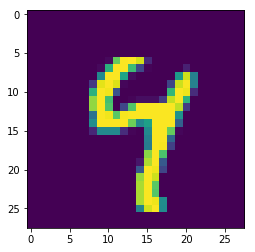

In [4]:
pic = data.train.images[2]
print(pic.shape)
plt.imshow(pic.reshape(28,28))

In [5]:
# parameter
#num of examples      size of the image(784)
num_train, shape_img = data.train.images.shape

shape_img = data.train.images[0].shape[0]

# input of generater
shape_noise = 100

# units of h_g
g_units = 256

# units of h_d
d_units = 256

# learning rate
lr = 0.001

##

down vote
From the DCGAN paper [Radford et al. https://arxiv.org/pdf/1511.06434.pdf]...

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling. This is in contrast to the original GAN paper, which used the maxout activation (Goodfellow et al., 2013)."

In [6]:
def generator(in_g, num_n, num_output,drop_rate=0.2, share=False):
    
    # hidden
    with tf.variable_scope("generator", reuse=share):
        h_g = tf.layers.dense(inputs=in_g, units=num_n)
        h_g = tf.nn.relu(h_g)
        h_g = tf.layers.dropout(h_g, drop_rate)

        # out
        logits_g = tf.layers.dense(h_g, rate=num_output)
        ##???? tanh
        out_g = tf.tanh(logits_g)
    
    return logits_g, out_g

In [7]:
def discriminator(in_d, num_n, share=False, drop_rate=0.2 ):
    
    with tf.variable_scope("discriminator", reuse=share):
    # hidden
        h_d = tf.layers.dense(in_d, num_n)
        h_d = tf.nn.relu(h_d)
        h_d = tf.layers.dropout(h_d, rate=drop_rate)

        # out
        logits_d = tf.layers.dense(h_d, 1)
        out_d = tf.sigmoid(logits_d)
    return logits_d, out_d

## Graph

In [8]:
tf.reset_default_graph()

real_pic = tf.placeholder(tf.float32, [None, shape_img], name='in_discriminator')
noise_pic = tf.placeholder(tf.float32, [None, shape_noise], name='in_gererator')

# g
logits_g, out_g = generator(noise_pic, g_units, shape_img)

# d
logits_d_real, out_d_real = discriminator(real_pic, d_units)
logits_d_fake, out_d_fake = discriminator(out_g, d_units, share=True)

## Loss

In [9]:
loss_d1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_d_real,labels=tf.ones_like(logits_d_real)))

loss_d2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_d_fake, labels=tf.zeros_like(logits_d_fake)))

# loss for d    d1+d2
loss_d = tf.add(loss_d1, loss_d2)

# loss for g
loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_d_fake, labels=tf.ones_like(logits_d_fake)))

In [10]:
parameter = tf.trainable_variables()
parameter

[<tf.Variable 'generator/dense/kernel:0' shape=(100, 256) dtype=float32_ref>,
 <tf.Variable 'generator/dense/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/dense_1/kernel:0' shape=(256, 784) dtype=float32_ref>,
 <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense/kernel:0' shape=(784, 256) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense_1/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) dtype=float32_ref>]

In [11]:
parameter_g = []
parameter_d = []
for para in parameter:
    if(para.name[0]=='g'):
        
        parameter_g.append(para)
for para in parameter:
    if(para.name[0]=='d'):
        parameter_d.append(para)
        
# define the optimizer of d and g

g_optimizer = tf.train.AdamOptimizer(lr).minimize(loss_g, var_list=parameter_g)
d_optimizer = tf.train.AdamOptimizer(lr).minimize(loss_d, var_list=parameter_d)

In [12]:
aa = data.train
aa.labels.shape
bb = aa.next_batch(10)
bb[1].shape



(10,)

In [26]:
# batch
batch_size = 64

# epoch
epochs = 300

# num of samples
num_sample = 25


get_pic = []
losses = []

# save
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(num_train//batch_size):
            batch = data.train.next_batch(batch_size)

            pic_batch = batch[0].reshape((batch_size, shape_img))
            pic_batch = 2*pic_batch-1

            # input for the generator
            in_g = np.random.uniform(-1, 1, size=(batch_size, shape_noise))

            # Optimzer
            _ = sess.run(d_optimizer, feed_dict={real_pic: pic_batch, noise_pic:in_g})
            _ = sess.run(g_optimizer, feed_dict={noise_pic: in_g})


        # loss
        train_loss_d = sess.run(loss_d, feed_dict={real_pic: pic_batch,
                                                   noise_pic: in_g})
        train_loss_d_real = sess.run(loss_d1, feed_dict={real_pic: pic_batch,
                                                   noise_pic: in_g})
        train_loss_d_fake = sess.run(loss_d2, feed_dict={real_pic: pic_batch,
                                                   noise_pic: in_g})

        train_loss_g = sess.run(loss_g, feed_dict={noise_pic: in_g})

        print("Epoch {}/{}...".format(e+1, epochs),
          "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
          "Generator Loss: {:.4f}".format(train_loss_g))

        # save the losses
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))

        # get the images in differen phases
        in_sample = np.random.uniform(-1, 1, size=(num_sample, shape_noise))
        pic_generate = sess.run(generator(noise_pic, g_units, shape_img,drop_rate=0.2, share=True),
                                feed_dict={noise_pic: in_sample})
        get_pic.append(pic_generate)
        get_pic
        # save the checkpoints for NN transfer
        saver.save(sess, '/check_NN/para_NN.ckpt')

with open('samples.pkl', 'wb') as f:
    pickle.dump(get_pic, f)



Epoch 1/300... Discriminator Loss: 0.0934(Real: 0.0015 + Fake: 0.0920)... Generator Loss: 3.0427
Epoch 2/300... Discriminator Loss: 0.5529(Real: 0.3961 + Fake: 0.1569)... Generator Loss: 6.6514
Epoch 3/300... Discriminator Loss: 0.5249(Real: 0.1465 + Fake: 0.3784)... Generator Loss: 2.5533
Epoch 4/300... Discriminator Loss: 0.8038(Real: 0.4027 + Fake: 0.4011)... Generator Loss: 3.3241
Epoch 5/300... Discriminator Loss: 0.9846(Real: 0.5396 + Fake: 0.4449)... Generator Loss: 2.4129
Epoch 6/300... Discriminator Loss: 2.2321(Real: 1.2735 + Fake: 0.9586)... Generator Loss: 2.2452
Epoch 7/300... Discriminator Loss: 0.6197(Real: 0.2840 + Fake: 0.3357)... Generator Loss: 2.5611
Epoch 8/300... Discriminator Loss: 1.4784(Real: 0.5177 + Fake: 0.9606)... Generator Loss: 2.3739
Epoch 9/300... Discriminator Loss: 0.7600(Real: 0.3067 + Fake: 0.4533)... Generator Loss: 1.7380
Epoch 10/300... Discriminator Loss: 0.8822(Real: 0.2670 + Fake: 0.6152)... Generator Loss: 1.5524
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.9099(Real: 0.4583 + Fake: 0.4516)... Generator Loss: 1.5002
Epoch 86/300... Discriminator Loss: 0.9030(Real: 0.5001 + Fake: 0.4028)... Generator Loss: 1.8189
Epoch 87/300... Discriminator Loss: 0.8738(Real: 0.5483 + Fake: 0.3255)... Generator Loss: 1.9269
Epoch 88/300... Discriminator Loss: 0.9060(Real: 0.3508 + Fake: 0.5553)... Generator Loss: 1.3263
Epoch 89/300... Discriminator Loss: 0.9110(Real: 0.3589 + Fake: 0.5520)... Generator Loss: 1.5149
Epoch 90/300... Discriminator Loss: 0.6615(Real: 0.2766 + Fake: 0.3849)... Generator Loss: 1.6178
Epoch 91/300... Discriminator Loss: 0.8046(Real: 0.3987 + Fake: 0.4059)... Generator Loss: 1.6395
Epoch 92/300... Discriminator Loss: 0.9281(Real: 0.5001 + Fake: 0.4280)... Generator Loss: 1.6288
Epoch 93/300... Discriminator Loss: 0.8844(Real: 0.4561 + Fake: 0.4283)... Generator Loss: 1.5503
Epoch 94/300... Discriminator Loss: 0.9807(Real: 0.3901 + Fake: 0.5906)... Generator Loss: 1.3672
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.8426(Real: 0.4840 + Fake: 0.3586)... Generator Loss: 1.8034
Epoch 169/300... Discriminator Loss: 0.8487(Real: 0.3699 + Fake: 0.4787)... Generator Loss: 1.4972
Epoch 170/300... Discriminator Loss: 0.8556(Real: 0.3410 + Fake: 0.5146)... Generator Loss: 1.5952
Epoch 171/300... Discriminator Loss: 0.8666(Real: 0.4048 + Fake: 0.4618)... Generator Loss: 1.6988
Epoch 172/300... Discriminator Loss: 0.9267(Real: 0.4926 + Fake: 0.4341)... Generator Loss: 1.7737
Epoch 173/300... Discriminator Loss: 0.9166(Real: 0.5276 + Fake: 0.3890)... Generator Loss: 1.7328
Epoch 174/300... Discriminator Loss: 0.8486(Real: 0.3562 + Fake: 0.4924)... Generator Loss: 1.4295
Epoch 175/300... Discriminator Loss: 1.0268(Real: 0.4932 + Fake: 0.5336)... Generator Loss: 1.4411
Epoch 176/300... Discriminator Loss: 0.8393(Real: 0.3166 + Fake: 0.5228)... Generator Loss: 1.5575
Epoch 177/300... Discriminator Loss: 0.8813(Real: 0.3160 + Fake: 0.5652)... Generator Loss: 1.2215
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.9033(Real: 0.4727 + Fake: 0.4306)... Generator Loss: 1.6863
Epoch 252/300... Discriminator Loss: 0.9461(Real: 0.4648 + Fake: 0.4812)... Generator Loss: 1.6991
Epoch 253/300... Discriminator Loss: 1.0088(Real: 0.3178 + Fake: 0.6910)... Generator Loss: 1.3080
Epoch 254/300... Discriminator Loss: 0.8921(Real: 0.4257 + Fake: 0.4665)... Generator Loss: 1.6966
Epoch 255/300... Discriminator Loss: 0.9024(Real: 0.4292 + Fake: 0.4732)... Generator Loss: 1.6420
Epoch 256/300... Discriminator Loss: 0.8198(Real: 0.3476 + Fake: 0.4722)... Generator Loss: 1.7179
Epoch 257/300... Discriminator Loss: 0.8655(Real: 0.4595 + Fake: 0.4060)... Generator Loss: 1.7128
Epoch 258/300... Discriminator Loss: 1.0140(Real: 0.6159 + Fake: 0.3981)... Generator Loss: 1.8948
Epoch 259/300... Discriminator Loss: 0.7500(Real: 0.4115 + Fake: 0.3385)... Generator Loss: 1.7391
Epoch 260/300... Discriminator Loss: 1.0295(Real: 0.6132 + Fake: 0.4163)... Generator Loss: 1.8741
Epoch 261/

In [27]:
with open('samples.pkl', 'rb') as f:
    pic_generate = pickle.load(f)
    
def show_pic_g(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes
    

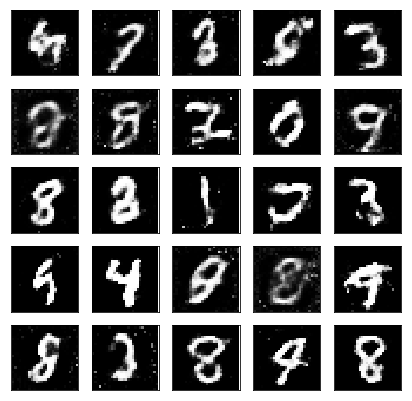

In [29]:
_ = show_pic_g(-1, pic_generate)

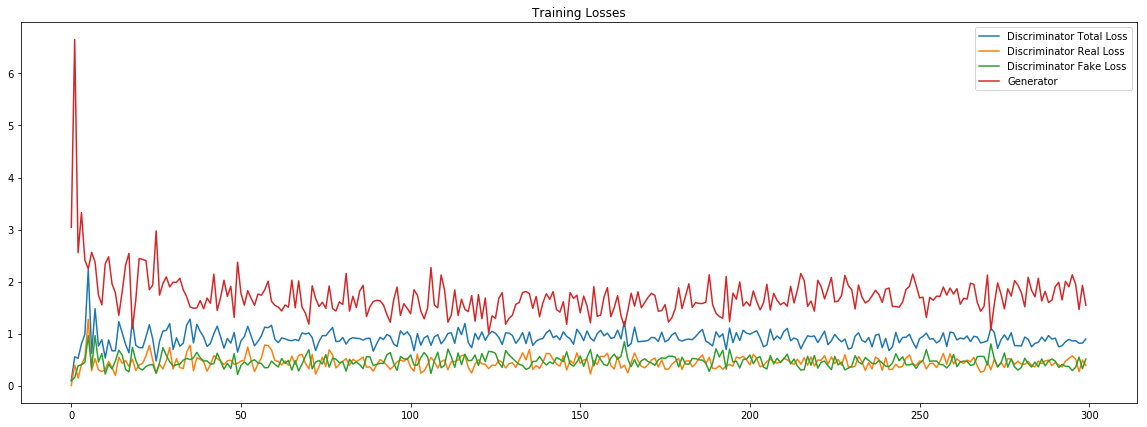

In [41]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()